# Day 25- Beginner Data Science Project

## Predict Housing Prices using a selection of features in the [Centadata set](http://centadata.publicdata.hk)

### The Data Science Process:
1. Perform Exploratory data analysis
2. Cleanup and replace missing values or drop columns as required.
3. Predict the target variable.
4. Evaluate the accuracy of the model
5. Perform Cross validation of your model and tabulate results.
6. Can you improve the model performance? if yes, how? 
7. Apply more than one possible algorithm on the data to compare and evaluate performance?
8. Recommend the best algorithm given the dataset and its features.
9. Prepare a presentation for each of your findings and recommendation.

In [20]:
import requests, json
import pandas as pd
from urllib.parse import urlencode

base_url = 'https://centadata.publicdata.hk/centadata-54990be.json'
params = {
    "sql": "select * from centadataall where txdate > '2017-01-01'"
}
url_params = urlencode( params )
target_url = base_url + "?" + url_params

data = requests.get( base_url, params )

if data.status_code == 200:
    cdata = json.loads( data.text )
    raw = pd.DataFrame(data = cdata['rows'],
                     columns = cdata['columns']
                     )
else:
    print(f"Can't download data with error code:{data.status_code} for {target_url}")

In [21]:
raw.dtypes

unitcode                      object
txdate                        object
price                          int64
buildingcode                  object
saleablearea                 float64
grossarea                    float64
xaxis                         object
yaxis                         object
buildingname                  object
phasecode                     object
phasename                     object
estatecode                    object
estatename                    object
buildingaddress               object
dateofcompletion              object
numberofunits                  int64
numberoffloors                 int64
flatsperfloor                  int64
schoolnet                     object
buildingnamechinese           object
phasenamechinese              object
estatenamechinese             object
buildingaddresschinese        object
region                        object
regionchinese                 object
regioncode                     int64
propertydeveloperchinese      object
p

Let's drop some obviously unneccessary columns

... and some not so obvious:
1. _Building Name_, _Phase Name_, _Estate Name_: the name basically describle the same dimension of information as the address and region does
2. _xaxis_: too building specific
* _property developer_ & _property manager_: this probably has some impact on the value but encoding this could be a challenge

and **building address**, is a higher dimenion of the `schoolnet` and `region` data that is potentially very important. **A useful thing to do is actually to run an unsupervised ML model on the address with prices to discover different pockets in Hong Kong.** This can be visually represented further on a map. The _pockets_ or clusters can be passed further back into the regression model as a feature to help improve the model's predictability.

In [59]:
l_col_to_drop = [
    'unitcode', 'buildingcode', 'buildingname',
    'xaxis',
    #'buildingaddress',
    'phasecode', 'phasename',
    'estatecode', 'estatename',
    'buildingnamechinese', 'phasenamechinese', 'estatenamechinese', 'buildingaddresschinese', 'regionchinese',
    'regioncode',
    'propertydeveloperchinese','propertyfacilitieschinese','propertymanagerchinese'
]
df = raw.drop( columns = l_col_to_drop )

In [60]:
df.head()

,txdate,price,saleablearea,grossarea,yaxis,buildingaddress,dateofcompletion,numberofunits,numberoffloors,flatsperfloor,schoolnet,region
0,2017-02-16,2880000,392.0,NaN,2/F,205A TUNG CHOI STREET,1963-08-01,8,8,1,九龍區32號校網,Mongkok/Yaumatei
1,2018-01-11,3000000,392.0,NaN,3/F,205A TUNG CHOI STREET,1963-08-01,8,8,1,九龍區32號校網,Mongkok/Yaumatei
2,2017-06-26,51000000,1912.0,2500.0,5/F,4A-4B WONG NAI CHUNG GAP ROAD,1965-09-01,8,8,1,香港區12號校網,Happy Valley/Mid Level East
3,2018-03-21,4150000,294.0,487.0,16/F,98 TSEUK LUK STREET,1999-01-01,30,15,2,九龍區43號校網,Diamond Hill/Wong Tai Sin
4,2017-11-28,5250000,530.0,NaN,8/F,54-58 SOUTH WALL ROAD,1969-10-01,32,9,4,九龍區41號校網,Diamond Hill/Wong Tai Sin


## Preliminary

In [28]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Exploratory Data Analysis & 2. Data Wrangling
### Missing Data

Text(176,0.5,'missing data')

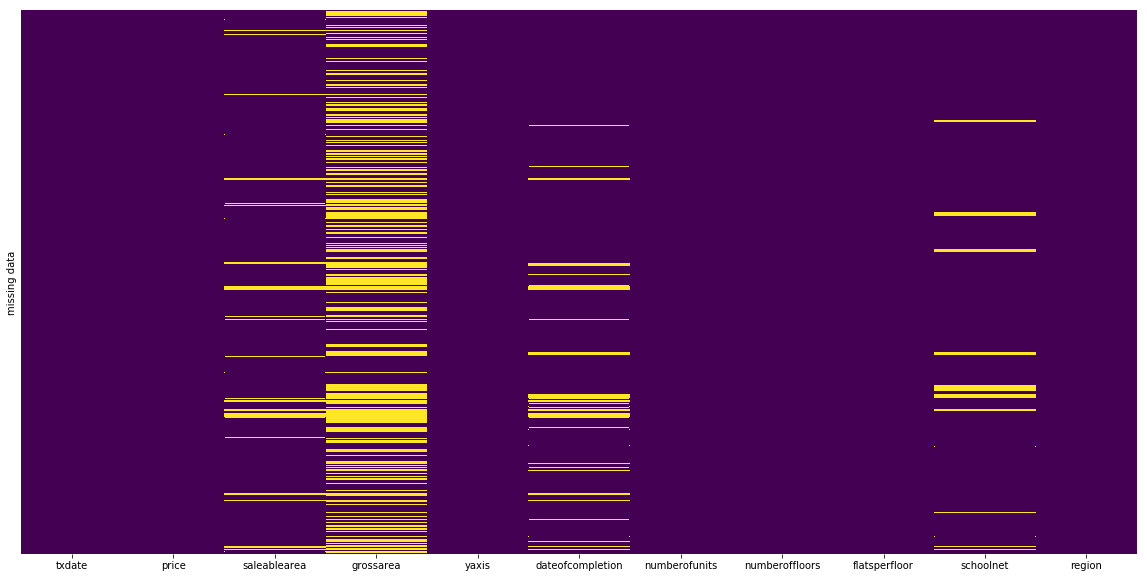

In [35]:
plt.figure(figsize = (20,10))
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')
plt.ylabel('missing data')

In [61]:
df_new = df.dropna()
print( f'original df shape: {df.shape}')
print( f'without missing data: {df_new.shape}')

original df shape: (100700, 12)
without missing data: (61501, 12)


### Data Cleaning
* `yaxis`: into `floor_number`
* `dateofcompletion`: into `building_age`
* `txdate`: into `deal_age`, `deal_year`

In [99]:
from datetime import datetime
today = datetime.today()

df_new['dateofcompletion'] = df_new['dateofcompletion'].astype('datetime64[ns]')
df_new['txdate'] = df_new['txdate'].astype('datetime64[ns]')

df_new['building_age'] = df_new['dateofcompletion'].apply(lambda x: (today - x).days)
df_new['deal_age'] = df_new['txdate'].apply(lambda x: (today - x).days)
df_new['deal_year'] = df_new['txdate'].apply(lambda x: x.year)

/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [77]:
import re

def get_floor_num(x):
    m = re.search(r'(\d+|G{1})/F', x)
    num = 0  # set to 0 by default; lots of whole buildings
    if m is None:
        if x == 'L/G':
            num = -1
        elif x == 'U/G':
            num = 0.5
    else:
        num = m.group(1)
        if num == 'G':
            num = 0
    return num

df_new['floor_number'] = df_new['yaxis'].apply( get_floor_num )

/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Normalize Prices
we are normalizing house price by year but there might be a smarter way, like getting Housing Price Index which the HK government does publish

In [100]:
df_pindex = df_new.groupby('deal_year')['price'].agg({'mean_price': 'mean', 'price_std': 'std'})
df_pindex

/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,mean_price,price_std
deal_year,,
2017,7.677761e+06,9.007902e+06
2018,8.897635e+06,9.060754e+06


In [116]:
def norm_price( row ):
    deal_year = row['deal_year']
    pmean = df_pindex[df_pindex.index == deal_year]['mean_price']
    pstd = df_pindex[df_pindex.index == deal_year]['price_std']
    nprice = (row['price'] - pmean )/ pstd
    return float(nprice.values)

df_new['norm_price'] = df_new.apply( norm_price, axis = 1)
df_new.head()

/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,txdate,price,saleablearea,grossarea,yaxis,buildingaddress,dateofcompletion,numberofunits,numberoffloors,flatsperfloor,schoolnet,region,building_age,deal_age,floor_number,deal_year,norm_price
2,2017-06-26,51000000,1912,2500,5/F,4A-4B WONG NAI CHUNG GAP ROAD,1965-09-01,8,8,1,香港區12號校網,Happy Valley/Mid Level East,19431,505,5.0,2017,4.809359
3,2018-03-21,4150000,294,487,16/F,98 TSEUK LUK STREET,1999-01-01,30,15,2,九龍區43號校網,Diamond Hill/Wong Tai Sin,7256,237,16.0,2018,-0.523978
5,2018-03-13,4000000,530,750,8/F,54-58 SOUTH WALL ROAD,1969-10-01,32,9,4,九龍區41號校網,Diamond Hill/Wong Tai Sin,17940,245,8.0,2018,-0.540533
7,2017-11-16,5150000,341,450,10/F,25-31 TSAT TSZ MUI ROAD,1977-07-01,88,22,4,香港區14號校網,North Point/Fortress Hill,15110,362,10.0,2017,-0.280616
8,2017-09-22,5080000,417,530,3/F,25-31 TSAT TSZ MUI ROAD,1977-07-01,88,22,4,香港區14號校網,North Point/Fortress Hill,15110,417,3.0,2017,-0.288387


### Exploratory Data Analysis

/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


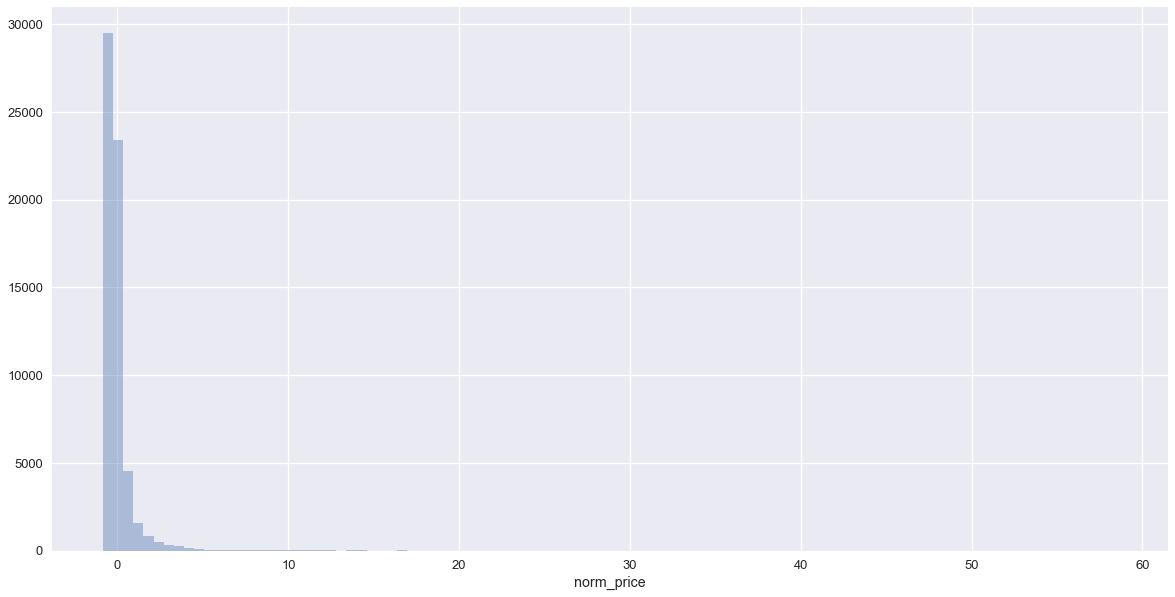

In [121]:
plt.figure(figsize = (20,10))
sns.set(style = 'darkgrid', context = 'talk')
sns.distplot(df_new['norm_price'], kde = False, bins = 100)


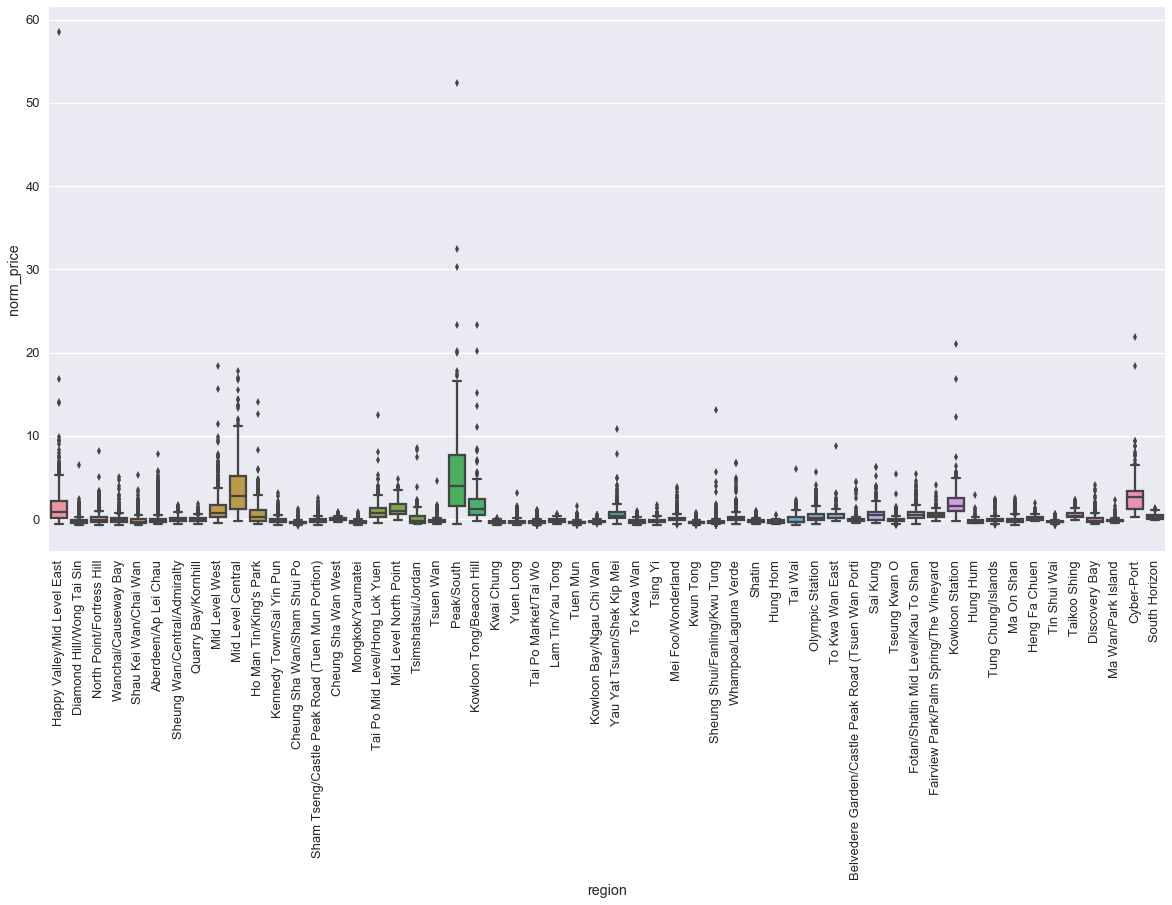

In [117]:
plt.figure(figsize = (20,10))
sns.set(style = 'darkgrid', context = 'talk')
bplot = sns.boxplot(y ='norm_price', x = 'region', data = df_new)
for label in bplot.get_xticklabels():
    label.set_rotation(90)
#plt.ylabel('missing data')

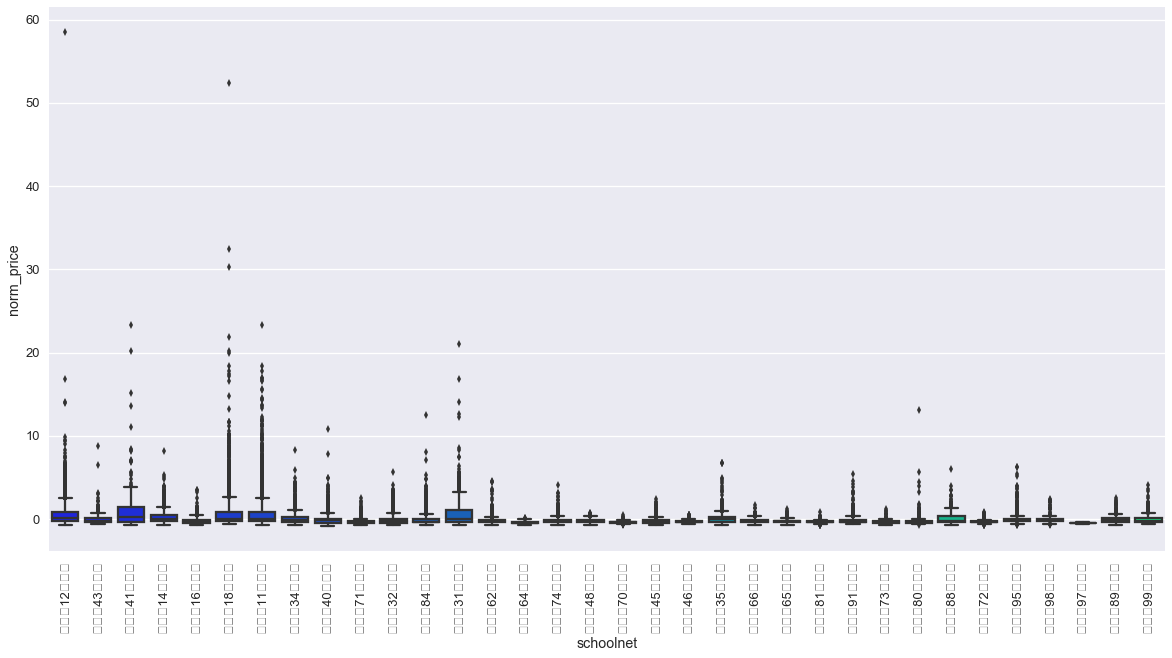

In [124]:
plt.figure(figsize = (20,10))
bplot = sns.boxplot(y ='norm_price', x = 'schoolnet', data = df_new, palette = 'winter')
for label in bplot.get_xticklabels():
    label.set_rotation(90)

/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


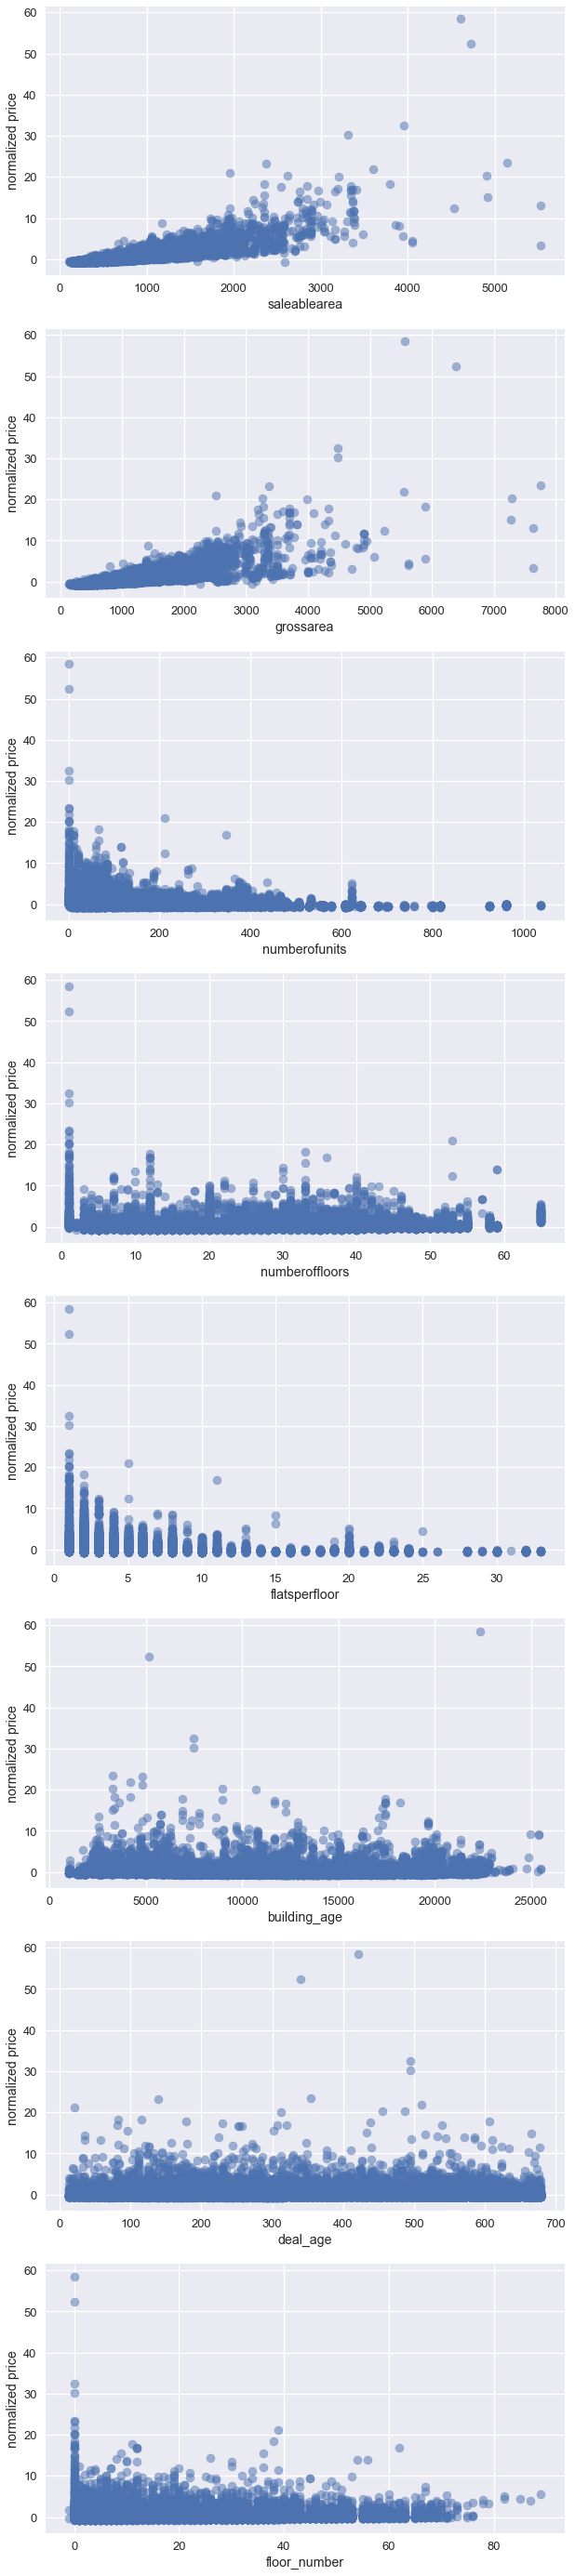

In [123]:
l_numerical = [
    'saleablearea', 'grossarea', 'numberofunits', 'numberoffloors', 'flatsperfloor', 
    'building_age', 'deal_age', 'floor_number'
]
df_new[l_numerical[:-1]] = df_new[l_numerical[:-1]].astype('int64')
df_new['floor_number'] = df_new['floor_number'].astype('float64')

fig, axe = plt.subplots(8, 1, figsize = (10,50))
for i, col in enumerate(l_numerical):
    axe[i].scatter(x = df_new[col], y = df_new['norm_price'], alpha = 0.5)
    axe[i].set_ylabel('normalized price')
    axe[i].set_xlabel(col)

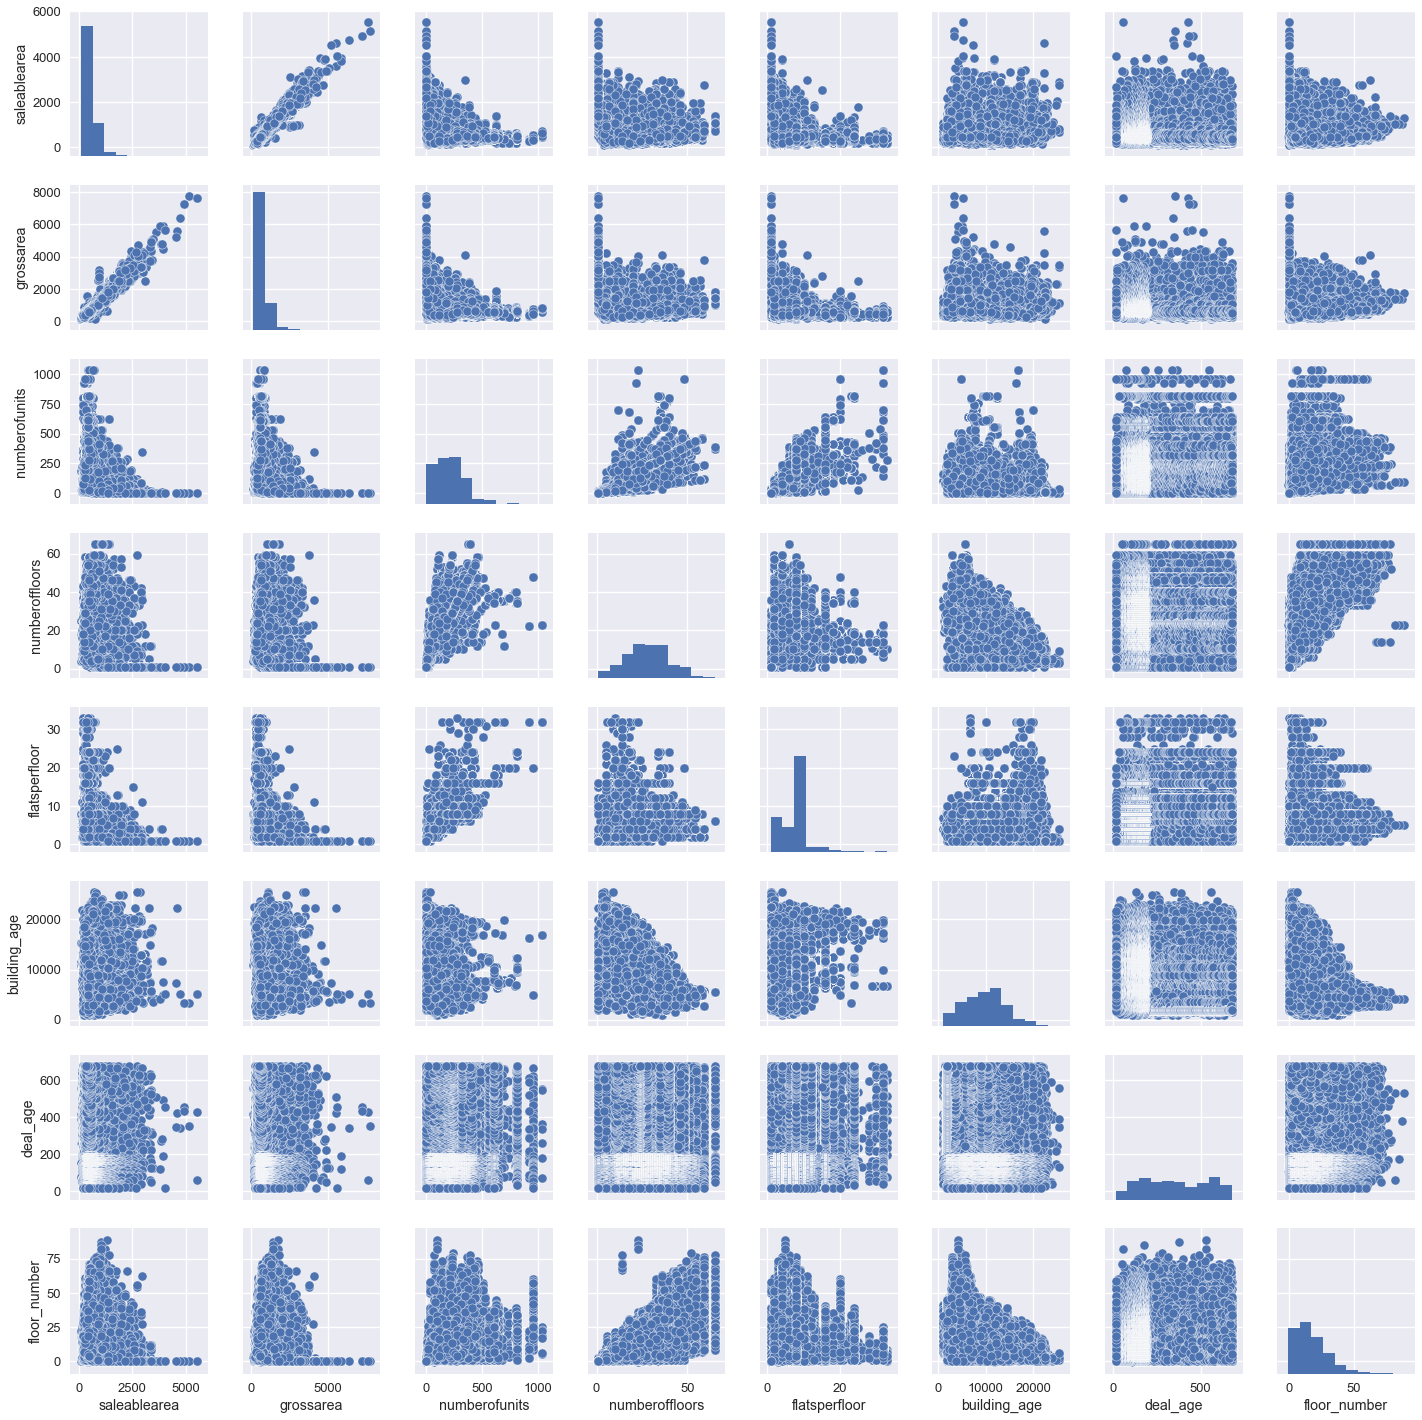

In [125]:
sns.pairplot(df_new[l_numerical])